In [ ]:
!pip install tiktoken


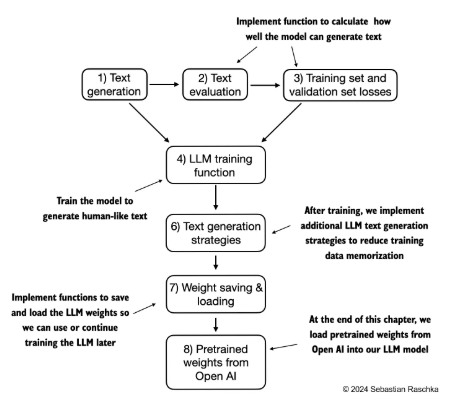

## 1) I wrote the code of the gpt model with random weights in the prev note book . <br>
2) we the the results are bad becuse model is not trained
3) we know that for training we follow the strategy of minimizing the loss function . here also for traing the model we need to make a loss function and then we will decrease it

In [ ]:
import torch
from prev_codes_4 import GPTModel

GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();  # Disable dropout during inference

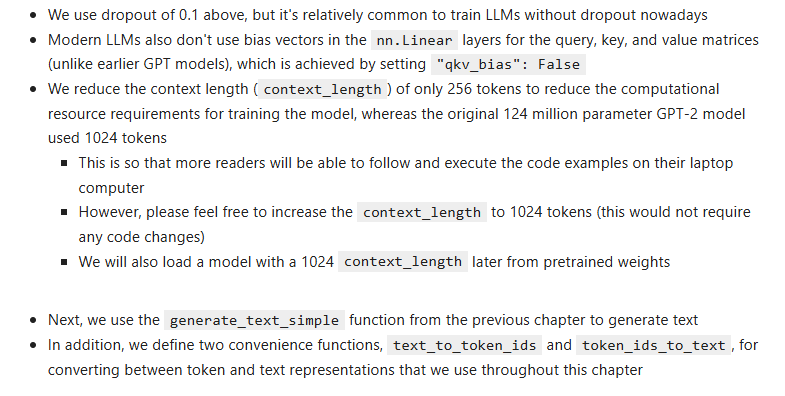

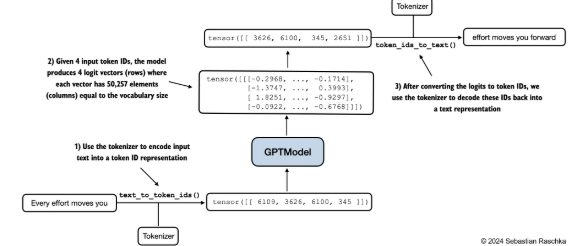

In [ ]:
import tiktoken


In [ ]:
# text to token function
def text_to_token_ids(text , tokenizer):
  encoded = tokenizer.encode(text , allowed_special = {'<|endoftext|'})
  encoded_tensor = torch.tensor(encoded).unsqueeze(0)
  # we are adiiing the batch dim
  return encoded_tensor

In [ ]:
# token to text function
def token_ids_to_text(token_ids , tokenizer):
  flat = token_ids.squeeze(0)
  return tokenizer.decode(flat.tolist())
  # .tolist so that tensor is converted to list


In [ ]:
# lets test the above functions
tokenizer = tiktoken.get_encoding("gpt2")
inp = "Every effort moves you"

In [ ]:
from prev_codes_4 import generate_text_simple

out_ids = generate_text_simple(
    model = model ,
    idx = text_to_token_ids(inp , tokenizer) ,
    max_new_tokens = 10,
    context_size = GPT_CONFIG_124M["context_length"]
)

print("Output text : \n " , token_ids_to_text(out_ids , tokenizer))

Output text : 
  Every effort moves you rentingetic wasnم refres RexMeCHicular stren


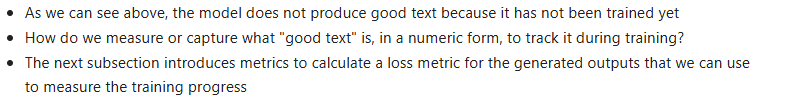

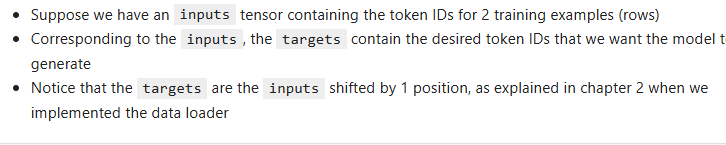

In [ ]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

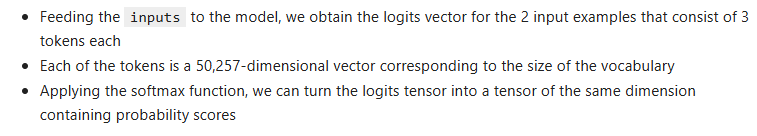

In [ ]:
with torch.no_grad():
  logits = model(inputs)
probas = torch.softmax(logits , dim = -1 )
 # Probability of each token in vocabulary
print(probas.shape)
# Shape: (batch_size, num_tokens, vocab_size)

torch.Size([2, 3, 50257])


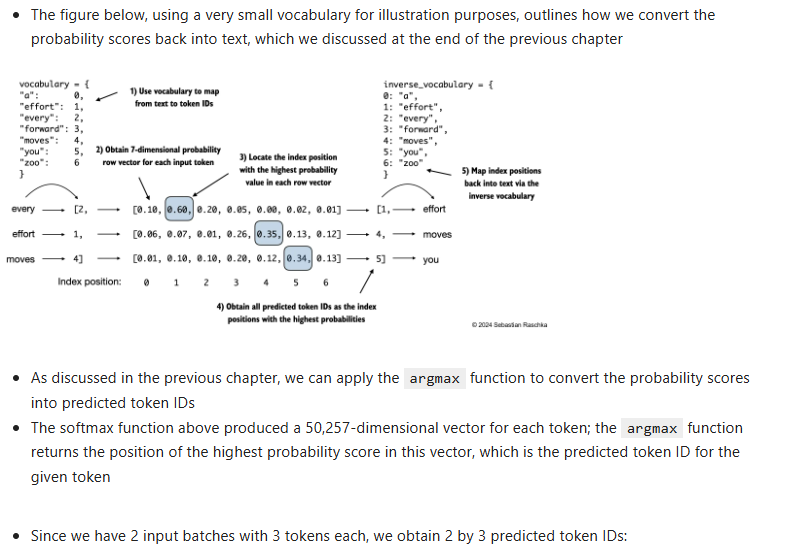

In [ ]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


note : 2 x 3 x 50257 means for each batch we have  3 x 50257 so for each token we will have one prediction . <br> but the only token we need generraly in the inference is last token

In [ ]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


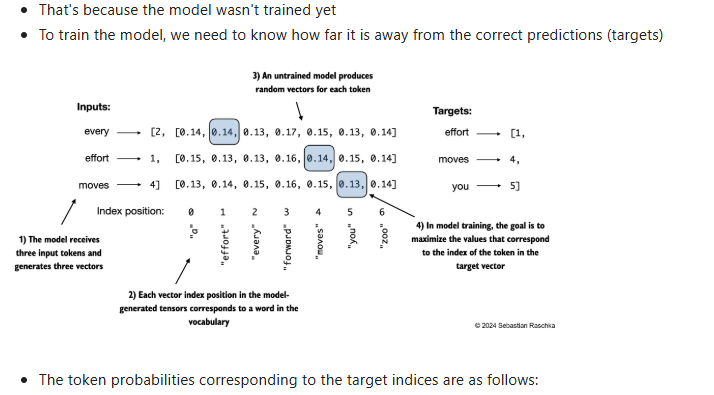

In [ ]:
#  see desired is ([[16833, 3626, 6100],
#          [40,    1107, 588]])
# this is what we got tensor([[[16657],
        #  [  339],
        #  [42826]],

        #  [[49906],
        #  [29669],
        #  [41751]]])
# we know the loss is generally in terms of the deviation of occured from the actual
# ie prob  should be 1 at the desired tokens but actually we get lesser.
# we will quantify this
text_idx = 0
target_probas_1 = probas[text_idx  , [0 , 1 , 2] , targets[text_idx]]
text_idx =  1
target_probas_2 = probas[text_idx  , [0 , 1 , 2] , targets[text_idx]]
print("Text 1:", target_probas_1)
print("Text 2:", target_probas_2)

Text 1: tensor([7.4540e-05, 3.1061e-05, 1.1563e-05])
Text 2: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


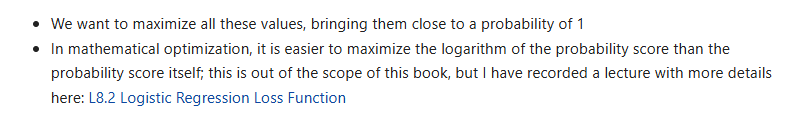

## when dealing with probablites we generally use the log terms beacuse the reason is in logistic regression

In [ ]:
log_probas = torch.log(torch.cat((target_probas_1  ,target_probas_2 ) ))
print(log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])


In [ ]:
# Calculate the average probability for each token
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.7940)


In [ ]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.7940)


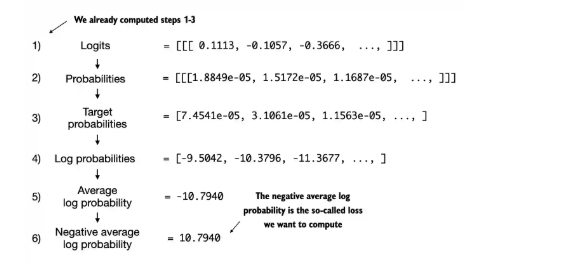

now lets caluclate the losss using the inbuilt cross entropy

In [ ]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()

print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


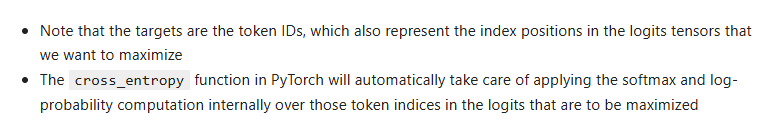

In [ ]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.7940)


In [ ]:
# see
print(f" dicrect method \n ")
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)
print("---" * 50 )
text_idx = 0
target_probas_1 = probas[text_idx  , [0 , 1 , 2] , targets[text_idx]]
text_idx =  1
target_probas_2 = probas[text_idx  , [0 , 1 , 2] , targets[text_idx]]
print("Text 1:", target_probas_1)
print("Text 2:", target_probas_2)
log_probas = torch.log(torch.cat((target_probas_1  ,target_probas_2 ) ))
print(log_probas)
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

 dicrect method 
 
tensor(10.7940)
------------------------------------------------------------------------------------------------------------------------------------------------------
Text 1: tensor([7.4540e-05, 3.1061e-05, 1.1563e-05])
Text 2: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])
tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])
tensor(-10.7940)
tensor(10.7940)


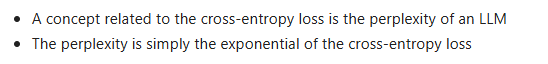

In [ ]:
perplexity = torch.exp(loss)
print(perplexity)

tensor(48725.8203)


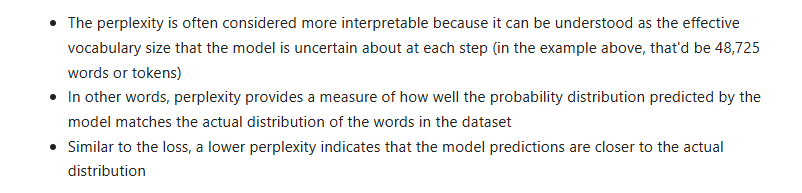

In [ ]:
# remebr the perplexity if anyone aksed
# 1) if the perpxelity is 43500 then it means for choosing the next item it is looking at the 43500 possible words ie
# it is like 43500 are nearly equi propabale
# 2) perplexity provides a measure of how well the probabiltiy distribution predicted by the
# model matches the actual distribution of hte wordds